In [58]:
import os;
import pandas as pd;
import tensorflow as tf; 
tf.reset_default_graph(); 
from src.modelFt import *; 
from src.utils import *
import math
import random
import seaborn
import sys
import sklearn

In [59]:
# Load word vectors and get data directory
encoder = "pcnn"
selector = "att"
dataset_name = "nyt2"
max_classes = 53
l2_lambd = 0.0
_, word_vec_mat = load_word_vec(os.path.join("data", "nyt2"))
data_dir = os.path.join("data", dataset_name)
fname_prefix = encoder + "_" + selector + "_" + dataset_name + "_ft_" + str(max_classes) + "_n_" + str(l2_lambd) + "_"
best_auc = 0.1
preprocessed_data_dir = get_preprocessed_dir(data_dir)
train_data = load_data(preprocessed_data_dir, max_classes)
test_data = load_data(preprocessed_data_dir, max_classes, "test")


In [60]:
# Converting data to entity pairs
n_epochs = 2

pair_bag_loc = train_data[-1]
pairs = list(pair_bag_loc.keys())
pairs_dict = get_dev_pairs_dict(pairs)
n_train_batches = len(pairs) // batch_size

test_pair_bag_loc = test_data[-1]
test_pairs = list(test_pair_bag_loc.keys())
test_pairs_dict = get_dev_pairs_dict(test_pairs)
n_test_batches = len(test_pairs) // batch_size

In [67]:
# Read json file for relation to ID
import json
with open("./data/nyt2/relToId.json", "r") as f:
    relToId = json.load(f)

# Read data for fine tuning
trainNonNA = []
for j in range(4):
    with open("saved/aucs/train_preds/pcnn_att_nyt2_none_53_n_0_0.3455_NonNA_{}__preds.csv".format(j), "r") as f:
        data = pd.read_csv(f1, prefix = "col", header = None)
        trainNonNA_ = data.col0.tolist()
        relsNonNa_ = ["#" + str(relToId[rel]) for rel in data.col2.tolist()]
        for i in range(len(trainNonNA_)):
            trainNonNA_[i] = trainNonNA_[i] + relsNonNa_[i]
        trainNonNA.extend(trainNonNA_)

trainNA = []
for j in range(1, 20):
    if j%5 == 0:
        print(j)
    with open("saved/aucs/train_preds/pcnn_att_nyt2_none_53_n_0_0.3455_NA_{}__preds.csv".format(j), "r") as f:
        data = pd.read_csv(f, prefix = "col", header = None)
    trainNA.extend([k + "#0" for k in data.col0.tolist()])
all_pairs = pairs
pairs = trainNA + trainNonNA
random.shuffle(pairs)
n_train_batches = len(pairs) // batch_size
not_NA_rels = 1950
print(len(trainNonNA), len(trainNA), not_NA_rels)

5
10
15
4000 19000 1950


In [68]:
def lr_vs_loss(model, start):
    random.shuffle(pairs)
    increments = 30
    no = 5 * increments
    split_pairs = [pairs[i * batch_size : (i + 1) * batch_size] for i in range(no)]
    x, y = model.print_lr_los(split_pairs, train_data, increments, start)
    seaborn.lineplot([math.log10(k) for k in x], y)

def test_model(batches, pairs, pairs_dict, processed_data, print_vals = False):
    test_res = []
    for i in range(batches):
        batch_keys = pairs[i * batch_size : (i + 1) * batch_size]
        words, pos1, pos2, inst_rels, masks, lengths, \
          rels, scope = batch_maker(processed_data, batch_keys)
        
        output, _ = model.test_batch(words, pos1, pos2, inst_rels, 
          masks, lengths, rels, scope)

        for i, k in enumerate(batch_keys):
            entPair = "#".join(k.split("#")[:2])
            entPairRels = pairs_dict[entPair]
            for j in range(1, max_classes):
                correct = 0
                if j in entPairRels:
                    correct = 1
                test_res.append({"entPair" : entPair, "actual" : entPairRels, "predicted" : j,
                  "score" : output[i][j], "correct" : correct})
    prec = []
    recall = []
    correct = 0
    sorted_test_result = sorted(test_res, key=lambda x: x['score'], reverse = True)

    import time
    start = time.time()
    if print_vals:
        for item in sorted_test_result[:100]:
            print(item["entPair"], item["actual"], item["predicted"], end=' -!-')

    
    for i, item in enumerate(sorted_test_result):
        if item["correct"]:
            correct += 1  
        prec.append(float(correct) / (i + 1))
        recall.append(float(correct) / not_NA_rels)
    auc = sklearn.metrics.auc(x = recall, y = prec)
    end = time.time()
    global best_auc
    if auc > best_auc:
        fname = fname_prefix + str(best_auc)[:6]
        if os.path.exists(fname):
           os.remove(fanme) 
        best_auc = auc
        fname = fname_prefix + str(auc)[:6] 
        print("Saving model {}".format(fname))
        model.msaver(os.path.join("saved", "models", fname))
    return auc

def train_epoch(pairs, epoch_no, learning_rate, model):
    losses = []
    aucs = []
    print("Setting learning rate for the epoch no {} to : {}".format(epoch_no, learning_rate))
    n_batches = len(pairs) // batch_size
    print("No of batches : {} \n ".format(n_batches))
    curr_pairs = pairs
    for i in range(n_batches):
        if i % 100 == 0:
            sys.stdout.write("\033[K")
            print("Running for batch : {}/{}".format(i + 1, n_batches))
        
        batch_keys = curr_pairs[i * batch_size : (i + 1) * batch_size]
        words, pos1, pos2, inst_rels, masks, lengths, \
            rels, scope = batch_maker(train_data, batch_keys)
        loss_, x= model.train_batch(
          words, pos1, pos2, inst_rels, masks, lengths,
          rels, scope, learning_rate)

        if loss_ > 10:
            temp = []
            for i in range(x.shape[0]):
                for j in range(x.shape[1]):
                    temp.append((x[i][j], i, j))
            print(sorted(temp, reverse = True)[:100])
            print(batch_keys[i])

        if i%500 == 250:
            print(i, end = " ")
            losses.append(loss_)
            auc1 = test_model(n_test_batches, test_pairs, test_pairs_dict, test_data)
            print("Test AUC : ", auc1)
            aucs.append(auc1)

    print("Testing after epoch : ")
    auc1 = test_model(n_test_batches, test_pairs, test_pairs_dict, test_data)
    print("Test Auc : ", auc1)
    aucs.append(auc1)
    return losses, aucs




In [80]:
check_pt = "pcnn_att_nyt2_none_53_n_0_0.3386"
tf.reset_default_graph()
model = ModelFt(
    word_vec_mat, 
    encoder = encoder, 
    selector = selector, 
    l2_lambda = l2_lambd, 
    no_of_classes = max_classes, load_logit=False)
model.mloader(os.path.join("saved", "models", check_pt))
model.reset_optimizer()

Creating model with encoder and selector :  pcnn att
121 (?, 120, 230)
121 (?, 120, 230)
(?, 690)
Created model with no bootstrapping, bs val : 0.0
Train vars last :  [<tf.Variable 'attention/logit/relation_matrix:0' shape=(53, 690) dtype=float32_ref>, <tf.Variable 'attention/logit/bias:0' shape=(53,) dtype=float32_ref>]
Train vars others :  [<tf.Variable 'word_embedding/word_embedding:0' shape=(114042, 50) dtype=float32_ref>, <tf.Variable 'word_embedding/unk_word_embedding:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'word_embedding/start_word_embedding:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'word_embedding/end_word_embedding:0' shape=(1, 50) dtype=float32_ref>, <tf.Variable 'pos_embedding/real_pos1_embedding:0' shape=(240, 5) dtype=float32_ref>, <tf.Variable 'pos_embedding/real_pos2_embedding:0' shape=(240, 5) dtype=float32_ref>, <tf.Variable 'pcnn/conv1d/kernel:0' shape=(3, 60, 230) dtype=float32_ref>, <tf.Variable 'pcnn/conv1d/bias:0' shape=(230,) dtype=float32_ref>

Saving temp model
Restoring temp model
INFO:tensorflow:Restoring parameters from /tmp/abcd


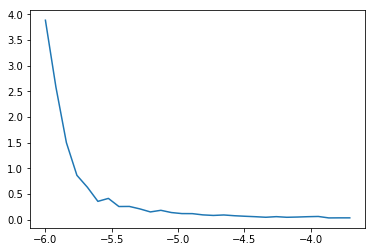

In [81]:
lr_vs_loss(model, 1e-6)

In [82]:
print("Training with all data.")
train_epoch(all_pairs[:len(all_pairs) // 2], 1, 1e-3, model)

Training with all data.
Setting learning rate for the epoch no 1 to : 0.001
No of batches : 2192 
 
Running for batch : 1/2192
Running for batch : 101/2192
Running for batch : 201/2192
250 Test AUC :  0.2243365062336267
Running for batch : 301/2192
Running for batch : 401/2192
Running for batch : 501/2192
Running for batch : 601/2192
Running for batch : 701/2192
750 Test AUC :  0.29727721355513764
Running for batch : 801/2192
Running for batch : 901/2192
Running for batch : 1001/2192
Running for batch : 1101/2192
Running for batch : 1201/2192
1250 Test AUC :  0.31851237965881884
Running for batch : 1301/2192
Running for batch : 1401/2192
Running for batch : 1501/2192
Running for batch : 1601/2192
Running for batch : 1701/2192
1750 Test AUC :  0.313884982079891
Running for batch : 1801/2192
Running for batch : 1901/2192
Running for batch : 2001/2192
Running for batch : 2101/2192
Testing after epoch : 
Test Auc :  0.3189055401357585


([0.16152012, 0.15178086, 0.10531716, 0.13332862],
 [0.2243365062336267,
  0.29727721355513764,
  0.31851237965881884,
  0.313884982079891,
  0.3189055401357585])

In [83]:
train_epoch(pairs, 1, 1e-3, model)

Setting learning rate for the epoch no 1 to : 0.001
No of batches : 359 
 
Running for batch : 1/359
Running for batch : 101/359
Running for batch : 201/359
250 Test AUC :  0.28775806865752196
Running for batch : 301/359
Testing after epoch : 
Test Auc :  0.2873739698493008


([0.00224147], [0.28775806865752196, 0.2873739698493008])

In [84]:
train_epoch(all_pairs[len(all_pairs) // 2:], 2, 1e-3, model)

Setting learning rate for the epoch no 2 to : 0.001
No of batches : 2192 
 
Running for batch : 1/2192
Running for batch : 101/2192
Running for batch : 201/2192
250 Test AUC :  0.32765615855546393
Running for batch : 301/2192
Running for batch : 401/2192
Running for batch : 501/2192
Running for batch : 601/2192
Running for batch : 701/2192
750 Test AUC :  0.32790966914867115
Running for batch : 801/2192
Running for batch : 901/2192
Running for batch : 1001/2192
Running for batch : 1101/2192
Running for batch : 1201/2192
1250 Test AUC :  0.3082702666139706
Running for batch : 1301/2192
Running for batch : 1401/2192
Running for batch : 1501/2192
Running for batch : 1601/2192
Running for batch : 1701/2192
1750 Test AUC :  0.3405799017308831
Running for batch : 1801/2192
Running for batch : 1901/2192
Running for batch : 2001/2192
Running for batch : 2101/2192
Testing after epoch : 
Test Auc :  0.33787259069607256


([0.11876035, 0.12948889, 0.10471433, 0.09758467],
 [0.32765615855546393,
  0.32790966914867115,
  0.3082702666139706,
  0.3405799017308831,
  0.33787259069607256])

In [85]:
train_epoch(pairs, 1, 1e-3, model)

Setting learning rate for the epoch no 1 to : 0.001
No of batches : 359 
 
Running for batch : 1/359
Running for batch : 101/359
Running for batch : 201/359
250 Test AUC :  0.30973568923026384
Running for batch : 301/359
Testing after epoch : 
Test Auc :  0.30917041368629866


([0.0011228989], [0.30973568923026384, 0.30917041368629866])

In [86]:
train_epoch(all_pairs[:len(all_pairs) // 2], 1, 1e-3, model)

Setting learning rate for the epoch no 1 to : 0.001
No of batches : 2192 
 
Running for batch : 1/2192
Running for batch : 101/2192
Running for batch : 201/2192
250 Test AUC :  0.3322176669327207
Running for batch : 301/2192
Running for batch : 401/2192
Running for batch : 501/2192
Running for batch : 601/2192
Running for batch : 701/2192
750 Test AUC :  0.3270888268407956
Running for batch : 801/2192
Running for batch : 901/2192
Running for batch : 1001/2192
Running for batch : 1101/2192
Running for batch : 1201/2192
1250 Test AUC :  0.3278238865312191
Running for batch : 1301/2192
Running for batch : 1401/2192
Running for batch : 1501/2192
Running for batch : 1601/2192
Running for batch : 1701/2192
1750 Test AUC :  0.3280877631281356
Running for batch : 1801/2192
Running for batch : 1901/2192
Running for batch : 2001/2192
Running for batch : 2101/2192
Testing after epoch : 
Test Auc :  0.33229537895272343


([0.10762696, 0.17016278, 0.042928748, 0.12298589],
 [0.3322176669327207,
  0.3270888268407956,
  0.3278238865312191,
  0.3280877631281356,
  0.33229537895272343])

In [87]:
train_epoch(pairs, 1, 1e-3, model)

Setting learning rate for the epoch no 1 to : 0.001
No of batches : 359 
 
Running for batch : 1/359
Running for batch : 101/359
Running for batch : 201/359
250 Test AUC :  0.31209249097784914
Running for batch : 301/359
Testing after epoch : 
Test Auc :  0.3101978692498739


([0.0016218817], [0.31209249097784914, 0.3101978692498739])

In [88]:
train_epoch(all_pairs[len(all_pairs) // 2:], 2, 1e-3, model)

Setting learning rate for the epoch no 2 to : 0.001
No of batches : 2192 
 
Running for batch : 1/2192
Running for batch : 101/2192
Running for batch : 201/2192
250 Test AUC :  0.33231717911356284
Running for batch : 301/2192
Running for batch : 401/2192
Running for batch : 501/2192
Running for batch : 601/2192
Running for batch : 701/2192
750 Test AUC :  0.33023730333686935
Running for batch : 801/2192
Running for batch : 901/2192
Running for batch : 1001/2192
Running for batch : 1101/2192
Running for batch : 1201/2192
1250 Test AUC :  0.3053215873445218
Running for batch : 1301/2192
Running for batch : 1401/2192
Running for batch : 1501/2192
Running for batch : 1601/2192
Running for batch : 1701/2192
1750 Test AUC :  0.3310073064622209
Running for batch : 1801/2192
Running for batch : 1901/2192
Running for batch : 2001/2192
Running for batch : 2101/2192
Testing after epoch : 
Test Auc :  0.3369745040978908


([0.06464577, 0.091266036, 0.1273012, 0.06926124],
 [0.33231717911356284,
  0.33023730333686935,
  0.3053215873445218,
  0.3310073064622209,
  0.3369745040978908])